# This Notebook analyzes how different Markov chains affect the spread and of a disease

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
import seaborn as sns
import pandas as pd

In [314]:
# Solves compartmental SIR model with transmission matrix beta (row: suscpetible, column: infected) and recovery vector omega

class MarkovSIR:
    def __init__(self, beta, omega, initial_s, initial_i, initial_r, endtime):
        self.cases = len(beta)
        self.b = beta
        self.k = omega
        self.S_0 = initial_s
        self.I_0 = initial_i
        self.R_0 = initial_r
        self.y0 = np.append(np.append(self.S_0, self.I_0), self.R_0)
        self.N = self.S_0 + self.I_0 + self.R_0
        self.t0 = 0
        self.tEnd = endtime
        
        self.simulation = []
        self.timestamps = []
        
    def fun(self, t, y):
        stois = []
        itors = []
        for idx in range(self.cases):
            stois.append(y[idx] * np.matmul(self.b[idx], y[self.cases:2 * self.cases]/self.N))
            itors.append(self.k[idx] * y[self.cases + idx])

        stois = np.array(stois)
        itors = np.array(itors)

        return np.append(np.append(-stois, stois - itors), itors)

    def simulate(self):
        sol = solve_ivp(self.fun, [self.t0 , self.tEnd], self.y0, method='BDF')
        self.simulation = sol.y
        self.timestamps = sol.t
    
    def plot(self, compartment = 0):
        for i in range(cases):
            plt.plot(self.timestamps, self.simulation[compartment * self.cases + i])
            
            
            

In [315]:
np.array([np.array([190, 100]), np.array([10, 0])]).flatten()

array([190, 100,  10,   0])

In [316]:
b = np.array([[0.1, 0.1], [1, 1]])
k = np.array([0.1, 0.05])

In [325]:
mks = MarkovSIR(b, k, np.array([190, 100]), np.array([10, 0]), np.array([0, 0]), 100)

In [326]:
mks.simulate()

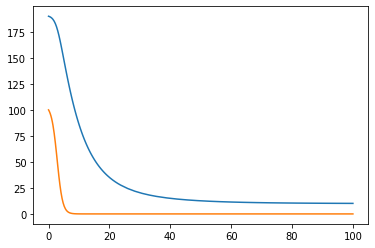

In [327]:
mks.plot()

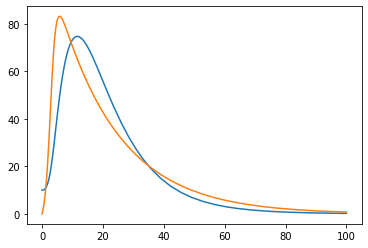

In [328]:
mks.plot(1)

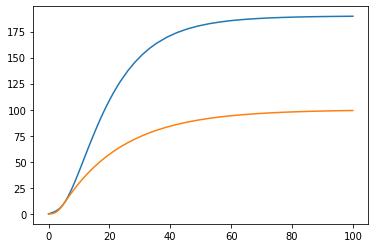

In [329]:
mks.plot(2)

In [52]:
# Solving for beta

# TODO: beta is made up of encounter rate and infection rate -> can separate for a more accurate model